# Sesión 8 - Implementación de algoritmos Actor-Critic: A2C/A3C

> En la presente sesión, se va a desarrollar la **implementación**  algoritmos avandos dentro de la familia de **Policy Gradients (PG)** En concreto, se va a implementar la variabte **Asyncronous Advantadge Actor-Critic (A3C)**. Esta versión incorpora ciertos avances con respecto al algoritmo PG, como son el uso de la función de ventaja como ponderación de los gradientes, su estimación mediante una función Critic, y exploración multiproceso asíncrona. La implementación será realizada utilizando la librería **pytorch**. Finalmente, se realizarán visualizaciones de KPIs del proceso de entrenamiento, con tal de analizar su convergencia.





---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.



---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/VIU/08_AR_MIAR/sesiones_practicas/sesion_practica_2"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

---
### 1.4. Instalar librerías necesarias


In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

---
## **PARTE 2** - *Entrenamiento de A3C*


---
### 2.1. A3C Pseudo-código

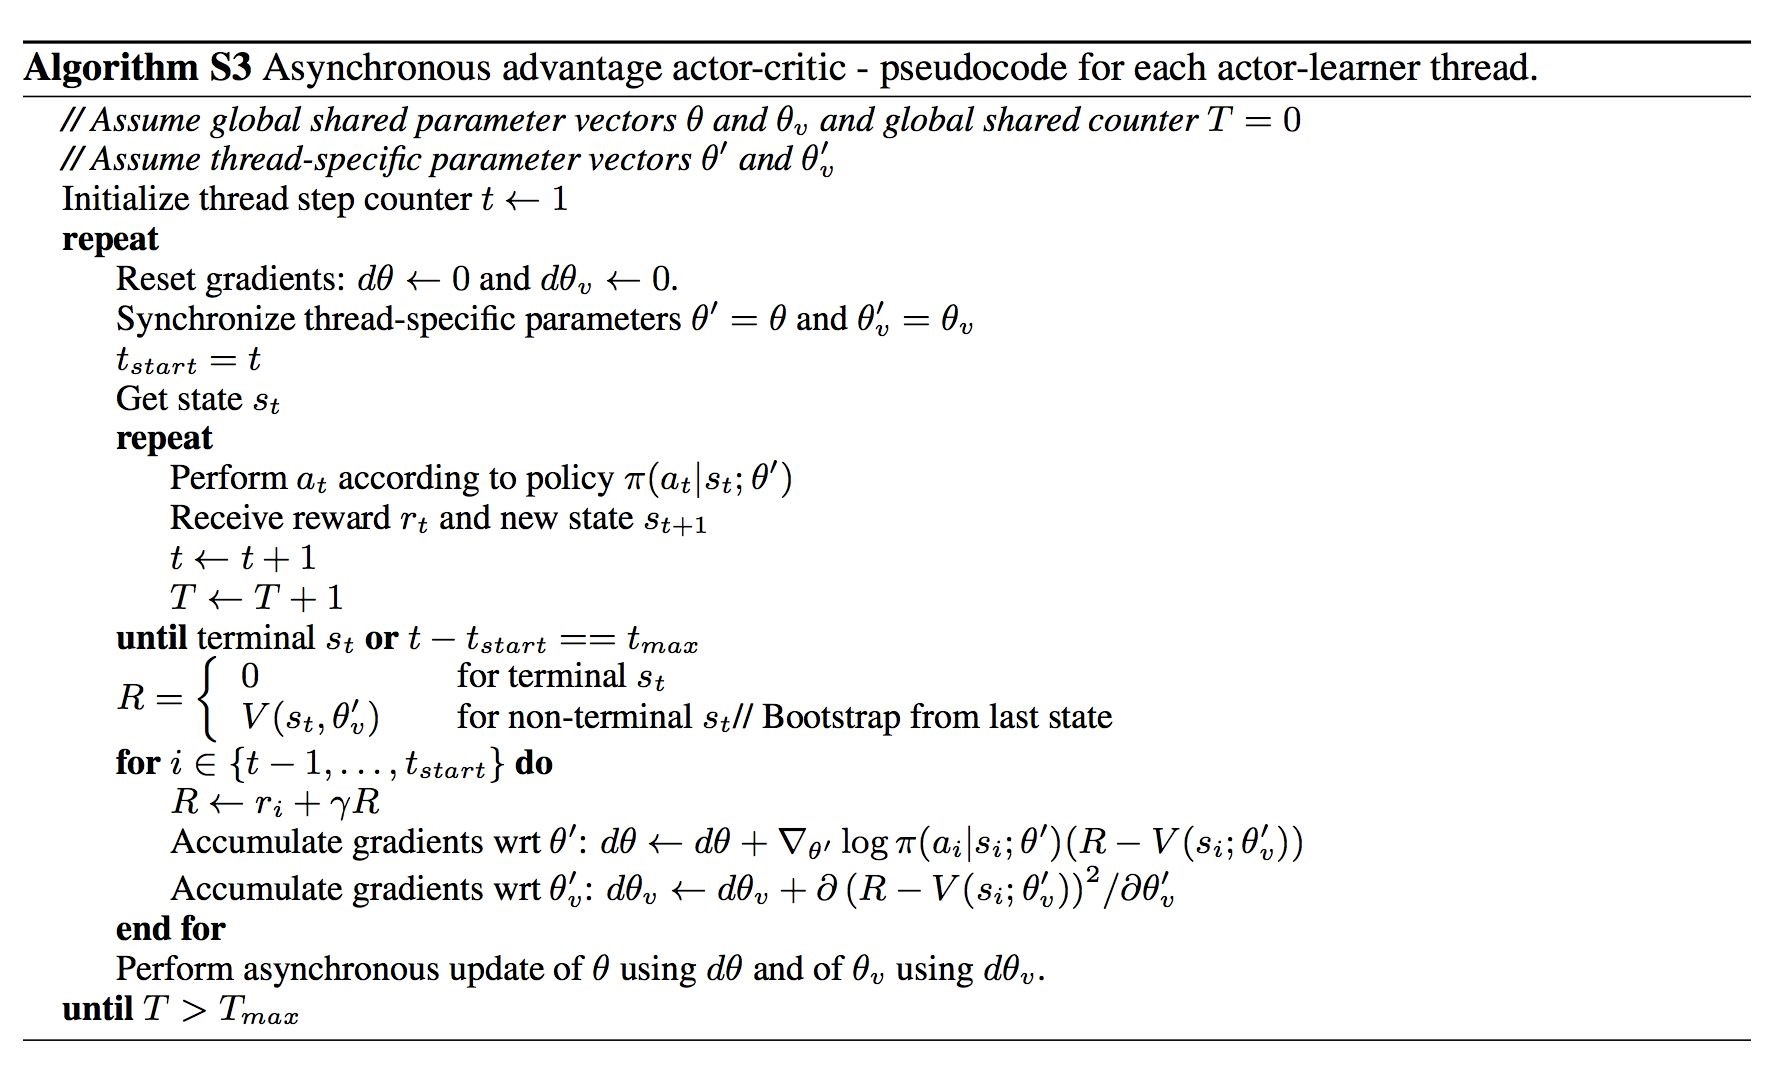

In [ ]:
from IPython import display
display.Image("images/a3c.jpg", width = 600, height = 400)

---
### 2.2. Ejemplo de A3C con pytorch - Breakout

Información del entorno:
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Basado en: https://github.com/ikostrikov/pytorch-a3c

Importamos el entorno y obtenemos el tamaño de la observación obtenida.

In [ ]:
import gym

env = gym.make('BreakoutDeterministic-v4')
obs = env.reset()
print(obs.shape)

Lanzamos el entrenamiento de A3C en multiproceso, a partir de las funciones definitas en "a3c_full.py". Para más detalles, véase dichas funciones.

In [ ]:
import torch
from a3c_full import *

# Semilla aleatoria para reproducibilidad
torch.manual_seed(22)

# Instanciamos el modelo global, compartido entre los distintos procesos
shared_model = ActorCritic()
shared_model.share_memory()

# Definimos el numero de procesoss utilizados para el entrenamiento.
# Asímismo, preparamos un buffer para tener los procesos, así como respectivos contadores

num_processes = 10
processes = []
counter = mp.Value('i', 0)
lock = mp.Lock()

# Lanzamos el proceso de testeo. Dicho proceso estará testeando continuamente.
# Asísmismo, obtendrá métricas de evolución y almacenará el mejor modelo.
print("Launching testing process")
p = mp.Process(
    target=test,
    args=(num_processes, EPISODES_TESTING, TRAINING_PARAMETERS,
        shared_model, counter, False, None))
p.start()
processes.append(p)

# Lanzamos, mediante un bucle, los procesos de entrenamiento asincronos definidos.
print("Launching {} training processes".format(num_processes - 1))
for rank in range(0, num_processes - 1):
  p = mp.Process(
      target=train,
      args=(rank, EPISODES_TRAINING, TRAINING_PARAMETERS, shared_model, counter, lock, None, None))
  p.start()
  processes.append(p)
for p in processes:
  p.join()

Launching testing process
Launching 9 training processes


Testeamos el modelo resultante

In [ ]:
from a3c_full import *

# Instanciamos la arquitectura del modelo
shared_model = ActorCritic()
# Cargamos los pesos del modelo entrenado
shared_model.load_state_dict(torch.load("breakout_a3c_fulltrain.pth"))
# Lanzamos
num_processes = 1
counter = mp.Value('i', 0)
lock = mp.Lock()
test(1, EPISODES_TESTING, TRAINING_PARAMETERS,
     shared_model, counter, lock, None)

---
## **PARTE 3** - *Análisis del entrenamiento*


Imports necesarios para estructurar los datos y visualizar las curvas de aprendizaje

In [1]:
import ast
import matplotlib.pyplot as plt
import pandas as pd

Cargamos el reporte del entrenamiento

In [2]:
lines = list(open("log_fulltrain.txt", 'r'))
print(lines)

["{'episode' 1, 'episode_time_secs' '3.91670298576355', 'episode_steps' '144', 'episode_reward' 0.0, 'reward_min' 0.0, 'reward_max' 0.0, 'reward_avg_by_step' 0.0, 'value_avg' -0.004148183, 'training_time' 3.91670298576355, 'training_steps' '1428'}\n", "{'episode' 2, 'episode_time_secs' '1.5882318019866943', 'episode_steps' '128', 'episode_reward' 0.0, 'reward_min' 0.0, 'reward_max' 0.0, 'reward_avg_by_step' 0.0, 'value_avg' 0.106110685, 'training_time' 5.504934787750244, 'training_steps' '2040'}\n", "{'episode' 3, 'episode_time_secs' '1.764186143875122', 'episode_steps' '135', 'episode_reward' 0.0, 'reward_min' 0.0, 'reward_max' 0.0, 'reward_avg_by_step' 0.0, 'value_avg' 0.084174044, 'training_time' 7.269120931625366, 'training_steps' '2701'}\n", "{'episode' 4, 'episode_time_secs' '1.8637311458587646', 'episode_steps' '132', 'episode_reward' 0.0, 'reward_min' 0.0, 'reward_max' 0.0, 'reward_avg_by_step' 0.0, 'value_avg' 0.06081156, 'training_time' 9.13285207748413, 'training_steps' '332

Re-organizamos los datos en el formato adecuado

In [3]:
data = []

for line in lines:
    data.append(ast.literal_eval(line.replace("' ", "': ")))

Organizamos los datos en una tabla, y visualizamos las primeras filas

In [4]:
df = pd.DataFrame(data)
df.head()

,episode,episode_time_secs,episode_steps,episode_reward,reward_min,reward_max,reward_avg_by_step,value_avg,training_time,training_steps
0,1,3.91670298576355,144,0.0,0.0,0.0,0.000000,-0.004148,3.916703,1428
1,2,1.5882318019866943,128,0.0,0.0,0.0,0.000000,0.106111,5.504935,2040
2,3,1.764186143875122,135,0.0,0.0,0.0,0.000000,0.084174,7.269121,2701
3,4,1.8637311458587646,132,0.0,0.0,0.0,0.000000,0.060812,9.132852,3327
4,5,2.81767201423645,202,2.0,0.0,1.0,0.009901,0.056209,11.950524,4327


Visualización - Tiempo de aprendizaje

In [5]:
print("Duración del entrenamiento en horas: " + str(df['training_time'].iloc[1464] / 60 / 60)) # Conversión de segundos a horas

Duración del entrenamiento en horas: 39.86047818554773


Visualización de curva de aprendizaje - Duración de las trayectorias.

<Axes: >

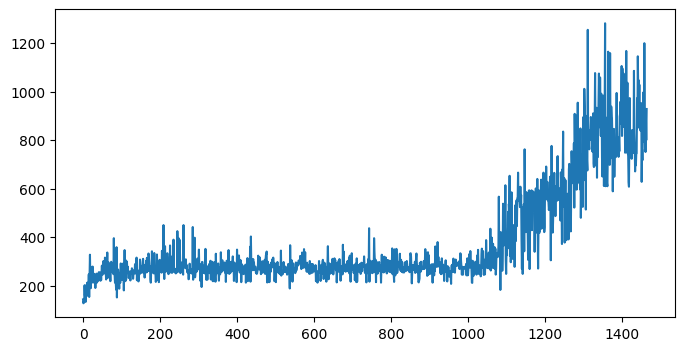

In [6]:
plt.figure(figsize=(8, 4))
df["episode_steps"].astype(int).plot()

Visualización de curva de aprendizaje - Value predicho.

<Axes: >

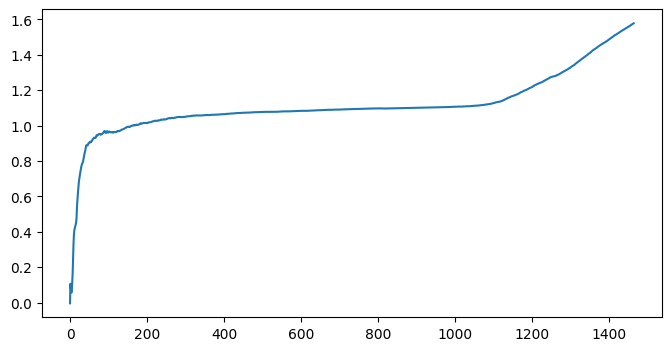

In [7]:
plt.figure(figsize=(8, 4))
df["value_avg"].astype(float).plot()

Visualización de curva de aprendizaje - Recompensa promedia.

<Axes: >

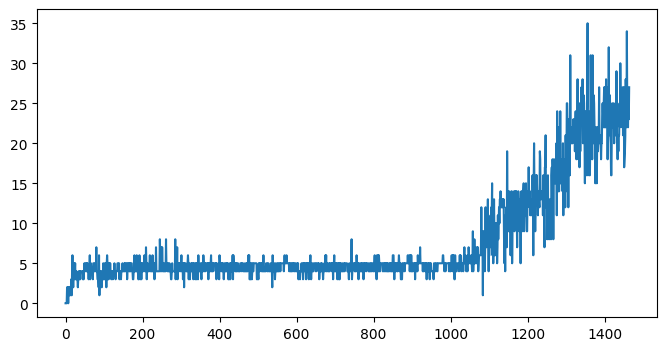

In [8]:
plt.figure(figsize=(8, 4))
df["episode_reward"].astype(float).plot()

---